<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построми модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.




## Подготовка

Импортируем нужные библиотеки и зафиксируем Random_state

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split


import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

state = np.random.RandomState(12345)


Сохраним таблицу в переменной, проиндексировав и отсортировав по дате

In [3]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [4]:
data.index.is_monotonic

True

Данные отсортированы, ресемплируем по 1часу:

In [5]:
data = data.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [6]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Создадим функцию для создания новых признаков:

In [7]:
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['6_hrs_lag'] = df['num_orders'].shift(6)
    df['12_hrs_lag'] = df['num_orders'].shift(12)
    df['24_hrs_lag'] = df['num_orders'].shift(24)
#    df['6_hrs_mean'] = df['num_orders'].rolling(window = 6).mean()
#    df['12_hrs_mean'] = df['num_orders'].rolling(window = 12).mean()
#    df['24_hrs_mean'] = df['num_orders'].rolling(window = 24).mean()
#    df['6_hrs_std'] = df['num_orders'].rolling(window = 6).std()
#    df['12_hrs_std'] = df['num_orders'].rolling(window = 12).std()
#    df['24_hrs_std'] = df['num_orders'].rolling(window = 24).std()
#    df['6_hrs_max'] = df['num_orders'].rolling(window = 6).max()
#    df['12_hrs_max'] = df['num_orders'].rolling(window = 12).max()
#    df['24_hrs_max'] = df['num_orders'].rolling(window = 24).max()
#    df['6_hrs_min'] = df['num_orders'].rolling(window = 6).min()
#    df['12_hrs_min'] = df['num_orders'].rolling(window = 12).min()
#    df['24_hrs_min'] = df['num_orders'].rolling(window = 24).min()
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear' , '6_hrs_lag' , '24_hrs_lag']]
    if label:
        y = df[label]
        return X, y
    return X


In [8]:
X_train, y_train = create_features(train, label='num_orders')
X_test, y_test = create_features(test, label='num_orders')

/tmp/ipykernel_154/2256144333.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df.index
/tmp/ipykernel_154/2256144333.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['date'].dt.hour
/tmp/ipykernel_154/2256144333.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

Проверим размер наших выорок

In [9]:
display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(3974, 10)

(442, 10)

(3974,)

(442,)

## Анализ

Для начала проанализируем тренды и сезонности для всех данных, для наглядности ресемплируем по дням:

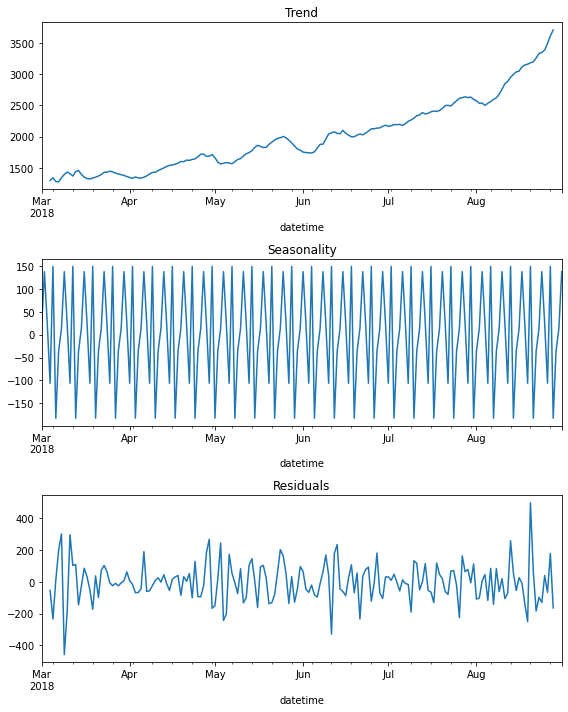

In [10]:
data_resampled_per_day = data.resample('1D').sum()
decomposed = seasonal_decompose(data_resampled_per_day)

plt.figure(figsize=(8, 10))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

По полученным данным можно сказать, что имеется тренд к увеличению количества заказов в день с апреля (1500 заказов), к сентябрю (больше 3000 заказов). Так же на графике сезонности отмечается по 4-5 пиков в каждом месяце, что говорит о том, что в какой то из дней недели на такси повышенный спрос.
Далее построим те же графики для марта:

Text(0.5, 1.0, 'Seasonality')

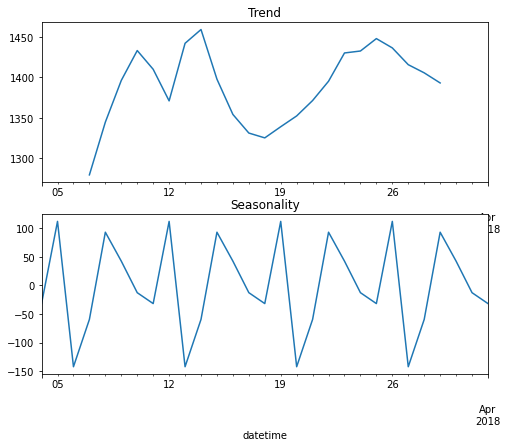

In [11]:
data_march = data['2018-03-04':'2018-04-01'].resample('1D').sum()

decomposed = seasonal_decompose(data_march)

plt.figure(figsize=(8, 10))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')



Отмечается тренд к небольшому общему увеличению количества заказов. При анализе сезонностей видно, что пики количества заказов приходятся на 5, 12, 19, 26 числа марта, что соответсвует понедельникам.

Далее попробуем проанализировать неделю марта:

Text(0.5, 1.0, 'Seasonality')

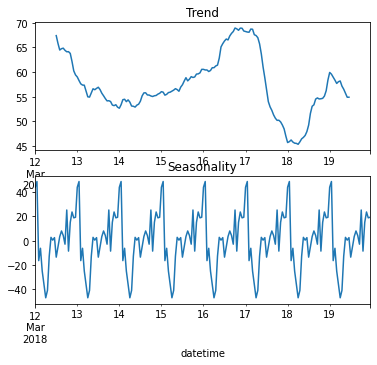

In [12]:
data_march = data['2018-03-12':'2018-03-19'].resample('1H').sum()

decomposed = seasonal_decompose(data_march)

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')



Отмечается тренд к увеличению заказов в выходные, в воскресение вечером и ночью отмечается низкий спрос. График сезонностей говорит о том, что каждый день есть пик спроса и его отсутствия, посмотрим в какое время это происзодит на следующем графике:

Text(0.5, 1.0, 'Seasonality')

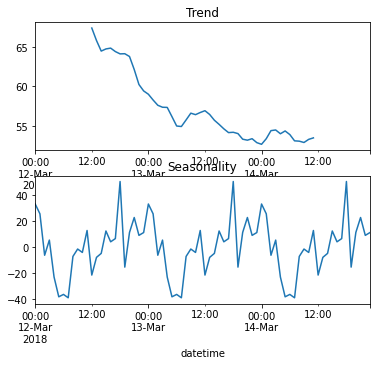

In [13]:
data_m = data['2018-03-12':'2018-03-14'].resample('1H').sum()

decomposed = seasonal_decompose(data_m)

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')


На данном графике сезонности видно, что спрос на такси растет утром, в полдень отмечается небольшой упадок, к 18.00 отмечается пик и весь вечер сохраняется хороший спрос, поздней ночью и ранним утром заказов очень мало.

## Обучение

Подберем гиперпараметры для моделей XGB и LGB с помощью поиска по сетке. Что бы кросс-валидцация не прохожила на данных, хронологически более ранних, используем TimeSeriesSplit, сохраним в переменной и передадим как аргумент для кросс-валидации в оптимизаторе.

In [14]:
%%time

tscv = TimeSeriesSplit(n_splits=5)

xgb_params = { 
    'learning_rate':[ 0.05 ],
    'max_depth' :[ 5, 10 ],
    'n_estimators': [100, 500]
}
xgbr = xgb.XGBRegressor(random_state=state)
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=xgb_params,
                   scoring='neg_mean_squared_error', 
                   verbose=1,
                   cv=tscv)
clf.fit(X_train, y_train)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**0.5)

CPU times: user 42 µs, sys: 7 µs, total: 49 µs
Wall time: 53.2 µs


In [15]:
%%time
lgb_model = lgb.LGBMRegressor(random_state=state)

lgb_params = {
    'task' : ['predict'],
    'boosting': ['gbdt' ],
    'objective': ['root_mean_squared_error'],
    'num_iterations': [  1500  ],
    'learning_rate':[ 0.05 ],
    'num_leaves':[ 5, 10 ],
    'max_depth' :[ 5, 10 ]
   
}

gsearch_lgb = GridSearchCV(lgb_model, param_grid = lgb_params, scoring='neg_root_mean_squared_error', n_jobs=6, verbose=10, cv = tscv)
gsearch_lgb.fit(X_train,y_train)
 
print('best params')
print (gsearch_lgb.best_params_)
score = gsearch_lgb.best_score_
print('RMSE:', -score)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV 5/5; 1/4] START boosting=gbdt, learning_rate=0.05, max_depth=5, num_iterations=1500, num_leaves=5, objective=root_mean_squared_error, task=predict
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV 5/5; 1/4] END boosting=gbdt, learning_rate=0.05, max_depth=5, num_iterations=1500, num_leaves=5, objective=root_mean_squared_error, task=predict; total time=   3.8s
[CV 5/5; 3/4] START boosting=gbdt, learning_rate=0.05, max_depth=10, num_iterations=1500, num_leaves=5, objective=root_mean_squared_error, task=predict
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV 5/5; 3/4] END boosting=gbdt, learning_rate=0.05, max_depth=10, num_iterations=1500, num_leaves=5, objective=root_mean_squared_error, task=predict; total time=   3.6s
[CV 4/5; 1/4] START boosting=gbdt,

RMSE лучше у модели LGB, проверим ее на тестовой выборке.

## Тестирование

In [16]:
params = gsearch_lgb.best_params_
model = lgb.LGBMRegressor(**params, random_state=state)
model.fit(X_train, y_train)
predict = model.predict(X_test)
print(mean_squared_error(predict, y_test)**0.5)


40.585637191074994
